In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import pairwise_distances
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from scipy.stats import pearsonr
from scipy import stats

z_thresh = 4
filepath = "F:/Two-Photon/Psilocybin Project/Evoked Cohort Mice/megadicts"

In [2]:
# Dictionary to map filenames to variable names
file_variable_mapping = {
    'saline_pre_dict.pkl': 'saline_pre',
    'saline_post_dict.pkl': 'saline_post',
    'psilo_pre_dict.pkl': 'psilo_pre',
    'psilo_post_dict.pkl': 'psilo_post'
}

# Initialize empty dictionaries
saline_pre = {}
saline_post = {}
psilo_pre = {}
psilo_post = {}

# Iterate through files in megadict folder
for filename in os.listdir(filepath):
    if filename in file_variable_mapping:
        file_path = os.path.join(filepath, filename)
        with open(file_path, 'rb') as file:
            # Load pkl file and assign to respective dictionary variable
            globals()[file_variable_mapping[filename]] = pickle.load(file)

In [3]:
# Create an array of all the matched cells that are sound-responsive in both recordings.  Each row is a matched cell pair. 
# INPUTS:  pre- and post- megadicts for a given drug condition. 
#          The specific recording to get matched cells for in the sub-dictionaries of pre- and post.
#          Code is written to be used with the matched cells bandwidth functions. 
# OUTPUTS: (npairs x 2) array containing the matched cell pairs that were responsive in both recordings. 

def get_consistently_responsive_cells(dict_pre,dict_post,sub_dict_pre,sub_dict_post):

    matched_responsive_1 = []
    matched_responsive_2 = []

    # Get the array of matched cell pairs stored under the dictionary's first cell key. 
    matched_cells = dict_post[sub_dict_post][next(iter(dict_post[sub_dict_post]))]['matched_cells']

    # iterate through each cell in the first dict and check if it is a matched cell pair.  Append the matched cells to a list.
    for cell in dict_pre[sub_dict_pre]:
            if cell in matched_cells[:,0] and dict_pre[sub_dict_pre][cell]['active'] == True:
                matched_responsive_1.append(cell)

    # Same operation but with the second dictionary.
    for cell in dict_post[sub_dict_post]:
            if cell in matched_cells[:,1] and dict_post[sub_dict_post][cell]['active'] == True:
                matched_responsive_2.append(cell)

    indices = np.where(np.isin(matched_cells[:, 0], matched_responsive_1))

    # Find the indices where the values in column 0 appear in the first match list.
    indices_col1 = np.isin(matched_cells[:, 0], matched_responsive_1)

    # Find the indices where the values in column 1 appear in the second match list. 
    indices_col2 = np.isin(matched_cells[:, 1], matched_responsive_2)

    # Combine the two conditions using logical AND
    combined_indices = np.logical_and(indices_col1, indices_col2)

    # Extract the rows where both conditions are true
    coactive = matched_cells[combined_indices]

    return coactive

In [4]:
def get_peak_matrix(cell,z_thresh):

    nfreq = list(cell['deconvolved_traces'].keys())
    nInt = list(cell['deconvolved_traces'][nfreq[0]].keys())
    ntrial = list(cell['deconvolved_traces'][nfreq[0]][nInt[0]].keys())

    matrix = np.array([[[cell['deconvolved_traces'][i][j][k] for k in ntrial] for j in nInt] for i in nfreq])

    matrix_corrected = np.zeros((12,4,10,10))

    baseline = np.mean(matrix[:, :, :, :5])
    corrected_cell = matrix[:,:,:,5:] - baseline
    matrix_corrected[:,:,:,:] = corrected_cell

    peak_matrix = matrix_corrected.max(axis=3)

    thresholded_peaks = np.where(peak_matrix < z_thresh, 0, peak_matrix)

    return thresholded_peaks


In [5]:
def get_correlation_matrix(peak_matrix):
    
    trial_no = peak_matrix.shape[2]

    correlation_matrix = np.zeros((trial_no, trial_no))
    p_value_matrix = np.zeros((trial_no, trial_no))

    for i in range(trial_no):
        for j in range(trial_no):
            if i == j:
                correlation_matrix[i, j] = 1.0  # Correlation with itself is 1.0
                p_value_matrix[i, j] = np.nan  # P-value is not defined for self-correlation
            else:
                correlation_matrix[i, j], p_value_matrix[i, j] = pearsonr(peak_matrix[:,:,i].flatten(), peak_matrix[:,:,j].flatten())

   
    return correlation_matrix, p_value_matrix


In [ ]:
# Mask upper triangle and diagonal
mask = np.triu(np.ones_like(correlation_matrix_2, dtype=bool), k=1)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_2, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.xlabel('Trial Index')
plt.ylabel('Trial Index')
plt.show()

In [6]:
def upper(df):
    '''Returns the upper triangle of a correlation matrix.
    You can use scipy.spatial.distance.squareform to recreate matrix from upper triangle.
    Args:
      df: pandas or numpy correlation matrix
    Returns:
      list of values from upper triangle
    '''
    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    return df[mask]

In [ ]:
"""Nonparametric permutation testing Monte Carlo"""
m1 = pd.DataFrame(correlation_matrix_1)
m2 = pd.DataFrame(correlation_matrix_2)


np.random.seed(0)
rhos = []
n_iter = 5000
true_rho, _ = stats.spearmanr(upper(m1), upper(m2))
# matrix permutation, shuffle the groups
m_ids = list(m1.columns)
m2_v = upper(m2)
for iter in range(n_iter):
  np.random.shuffle(m_ids) # shuffle list 
  r, _ = stats.spearmanr(upper(m1.loc[m_ids, m_ids]), m2_v)  
  rhos.append(r)
perm_p = ((np.sum(np.abs(true_rho) <= np.abs(rhos)))+1)/(n_iter+1) # two-tailed test


f,ax = plt.subplots()
plt.hist(rhos,bins=20)
ax.axvline(true_rho,  color = 'r', linestyle='--')
ax.set(title=f"Permuted p: {perm_p:.3f}", ylabel="counts", xlabel="rho")
plt.show()

In [ ]:
'''  
For every matched cell pair in the recording, compute the correlation matrix and get the p value for whether there's a pre- and post difference
How many have a significant difference between saline and psilocybin? 
'''

In [22]:
def get_spearman_corr_matched_cells(dict_pre,dict_post,z_thresh):

    matched_correlation_differences = []

    for sub_dict_pre, sub_dict_post in zip(dict_pre.keys(),dict_post.keys()):

        # Get the array of consistently responsive matched cell pairs for the pre- and post-conditions. 
        coactive = get_consistently_responsive_cells(dict_pre,dict_post,sub_dict_pre,sub_dict_post)

        # Initialize empty array to place bandwidths in.
        spearman_p_values = np.zeros_like(coactive[:,0])

        for i,cell_1, cell_2 in zip(range(len(coactive[:,0])),coactive[:,0],coactive[:,1]):
            peaks_pre = get_peak_matrix(dict_pre[sub_dict_pre][cell_1],z_thresh)
            peaks_post = get_peak_matrix(dict_post[sub_dict_post][cell_2],z_thresh)

            correlation_matrix_1,_ = get_correlation_matrix(peaks_pre)
            correlation_matrix_2,_ = get_correlation_matrix(peaks_post)

            m1 = pd.DataFrame(correlation_matrix_1)
            m2 = pd.DataFrame(correlation_matrix_2)

            spearman_corr, p_value = stats.spearmanr(upper(m1), upper(m2))
            print(p_value)

            spearman_p_values[i] = p_value
        
        matched_correlation_differences.append(spearman_p_values)

    matched_correlation_differences = np.concatenate(matched_correlation_differences)

    return matched_correlation_differences
            

In [23]:
corr_diff = get_spearman_corr_matched_cells(saline_pre,saline_post,z_thresh)

0.73033495048346
0.13095245057801072
0.03225438144970172
0.8507548163027883
0.6541226597980295
0.7225822985385244
0.14966236154421836
0.9890348502321256
0.3484207792493744
0.06850559570923959
nan


C:\Users\Conor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


ValueError: cannot convert float NaN to integer

In [25]:
coactive_test = get_consistently_responsive_cells(saline_pre,saline_post,'saline_1_186','saline_2_186')

print(coactive_test)

[[ 15   8]
 [ 28 116]
 [ 30  89]
 [ 34 213]
 [ 54  39]
 [ 55 126]
 [ 57 674]
 [ 58  15]
 [ 67  64]
 [109  50]
 [119 166]
 [121 352]
 [122 196]
 [125  62]
 [126 101]
 [128 343]
 [130 372]
 [131  46]
 [140 349]
 [142  67]
 [152 604]
 [170 150]
 [172  26]
 [175 390]
 [177 183]
 [190 135]
 [197 434]
 [213 368]
 [261 394]
 [298  30]
 [331 102]
 [355 129]
 [414  68]
 [419 229]
 [424 442]
 [426 276]
 [572 457]]


In [37]:
cell_pre = saline_pre['saline_1_186'][15]
cell_post = saline_post['saline_2_186'][8]

In [38]:
matrix_1 = get_peak_matrix(cell_pre,4)
print(matrix_1.shape)
matrix_2 = get_peak_matrix(cell_post,4)
print(matrix_1.shape)


(12, 4, 10)
(12, 4, 10)


In [40]:
corr_1 = get_correlation_matrix(matrix_1)

corr_2 = get_correlation_matrix(matrix_2)




TypeError: Invalid shape (2, 10, 10) for image data

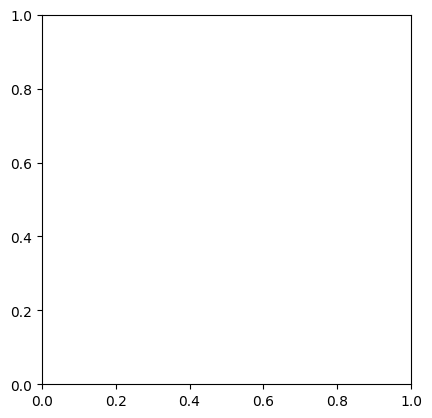

In [41]:
plt.imshow(corr_2)

In [32]:
# Mask upper triangle and diagonal
mask = np.triu(np.ones_like(corr_1, dtype=bool), k=1)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_1, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.xlabel('Trial Index')
plt.ylabel('Trial Index')
plt.show()

ValueError: Must pass 2-d input. shape=(2, 10, 10)

<Figure size 1000x800 with 0 Axes>

In [ ]:
# Calculate Frobenius norm? Doable in np.linalg.norm